In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]=""

In [11]:
import transformers
import pandas as pd
import re
from tqdm import tqdm
import numpy as np

In [2]:
!nvidia-smi

Sat Apr 30 05:42:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:5C:00.0 Off |                    0 |
| N/A   28C    P0    51W / 350W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Setup


In [10]:
!pip install transformers
#!pip install pytorch-lightning
!pip install datasets


In [5]:
!pip install transformers datasets accelerate nvidia-ml-py3


     |████████████████████████████████| 65 kB 3.6 MB/s eta 0:00:011


In [6]:
import os
from google.colab import drive
import matplotlib.pyplot as plt

In [7]:
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = './data/final_out_diploma.csv'
sample_path = './data/sample.csv'
json_path = './data/train.json'
uns_path = './data/uns42.csv'

In [ ]:
data_mlm = pd.read_csv(data_path)

In [ ]:
del data_mlm

In [4]:
from datasets import load_dataset

In [5]:
dataset_mlm = load_dataset('csv', data_files= data_path, split = 'train')

Using custom data configuration default-a6a36ff6539aeffa
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-a6a36ff6539aeffa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


In [6]:
dataset_mlm['text'][1]

'{$SPCE} {$VIPS} {$MOMO} {$ASTR} {$SBER} {$LKOH} {$TCSG} {$LI} {$AAPL} {$NVDA} {$POLY} {$PLZL@GS} {$USDRUB} \n \nВсем привет 👋\n\nВообщем... есть свободный лям (к сожалению рублей)\n\nГрамотные, понимающие и знающие люди, подскажите, куда сейчас можно закинуть этот лям, так чтобы процентов 40-50 за год было, сейчас лежит на накопительном счёте и капает 480 рублей в день 🤭😂\n\nМожет у кого есть реально интересные и перспективные идеи, здравые мысли..\n\nДавайте пообсуждаем эту тему в комментариях.'

In [7]:
dataset_mlm = dataset_mlm.train_test_split(test_size=0.2, seed = 1488)


Loading cached split indices for dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-a6a36ff6539aeffa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-374237f596905ef1.arrow and /home/jovyan/.cache/huggingface/datasets/csv/default-a6a36ff6539aeffa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-95c096490f96888e.arrow


### MLM Model

In [3]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

In [9]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-conversational")
model = AutoModelForMaskedLM.from_pretrained("./results_clf/checkpoint-103").to('cuda')

Some weights of the model checkpoint at ./results_clf/checkpoint-103 were not used when initializing BertForMaskedLM: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./results_clf/checkpoint-103 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
You sho

In [15]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-conversational")

In [10]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length = 128, padding = 'max_length')

In [11]:
tokenized_data = dataset_mlm.map(preprocess_function,remove_columns=dataset_mlm["train"].column_names)

  0%|          | 0/252246 [00:00<?, ?ex/s]

  0%|          | 0/63062 [00:00<?, ?ex/s]

In [ ]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 160000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 40000
    })
})

In [ ]:
tokenized_data['train']['attention_mask'][1]

In [12]:
from transformers import DataCollatorForLanguageModeling

In [13]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [14]:
from transformers import AutoModelForMaskedLM, TrainingArguments, Trainer

In [18]:
training_args = TrainingArguments(
    
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size = 16,
    save_total_limit=1,
    metric_for_best_model='loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=False

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    data_collator=data_collator
    
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend


In [19]:
trainer.train()

/home/jovyan/.imgenv-bert-0/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 252246
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 78830


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss
1,2.585900,2.421373
2,2.208000,2.106197
3,2.027300,1.958874
4,1.954500,1.890377
5,1.914100,1.866884


***** Running Evaluation *****
  Num examples = 63062
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-15766
Configuration saved in ./results/checkpoint-15766/config.json
Model weights saved in ./results/checkpoint-15766/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-40000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 63062
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-31532
Configuration saved in ./results/checkpoint-31532/config.json
Model weights saved in ./results/checkpoint-31532/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-45000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 63062
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-47298
Configuration saved in ./results/checkpoint-47298/config.json
Model weights saved in ./results/checkpoint-47298/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-15766] due to args.save_t

TrainOutput(global_step=78830, training_loss=2.310070596375805, metrics={'train_runtime': 14879.3423, 'train_samples_per_second': 84.764, 'train_steps_per_second': 5.298, 'total_flos': 8.3076683320512e+16, 'train_loss': 2.310070596375805, 'epoch': 5.0})

### TextClassification Model

##### Data Preprocessing

In [11]:
data_news = pd.read_json(json_path)

In [12]:
data = pd.read_csv(sample_path)

In [12]:
def preprocess_labels(label):
    if label == 'negative' or label == -1:
       label = 0
       return label
    if label == 'neutral' or label == 0:
       label = 1
       return label
    if label == 'positive' or label == 1:
       label = 2
       return label
    else:
       label = 3
    return label

In [13]:
def preprocess_data(data, label):
    data = data.dropna(axis=0)
    data['label'] = data[label].apply(lambda x: preprocess_labels(x))
    data = data[['text','label']]
    data = data[data.label.isin([0,1,2])]
    return data

In [15]:
data_news = preprocess_data(data_news, 'sentiment')

In [16]:
data_news.label.value_counts()

1    4034
2    2795
0    1434
Name: label, dtype: int64

<AxesSubplot:>

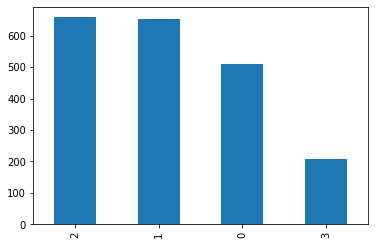

In [13]:
data.label.value_counts().plot.bar()

### Dataset

In [ ]:
!pip install pytorch-lightning

In [6]:
import torch

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import random_split

In [31]:
class TPDataset(Dataset):

  def __init__(self, task, dtype, data_path, tokenizer, labels, max_token_len: int = 256):
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
    self.labels = labels
    self.task = task
    self.dtype = dtype
    self._load_data()
    
  def _load_data(self):
    if self.task == 'train':
        if self.dtype == 'csv':
            data = pd.read_csv(self.data_path)
            self.data = preprocess_data(data, self.labels)
        if self.dtype == 'json':
            data = pd.read_json(self.data_path)
            self.data = preprocess_data(data, self.labels)
    else:
        self.data = pd.read_csv(self.data_path)
    
  def add_new_data(self, new_data_path):
    data = pd.read_csv(new_data_path)
    data = preprocess_data(data)
    self.data = self.data.append(data)
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data.iloc[index]
    text = str(item['text'])
    labels = torch.tensor(item['label'], dtype=torch.long)
    tokens = self.tokenizer.encode_plus(text,
                                        add_special_tokens = True,
                                       # return_tensors = 'pt',
                                        truncation = True,
                                        max_length = self.max_token_len,
                                        return_attention_mask=True)
    if self.task == 'train':
        return {'input_ids': tokens.input_ids, 'attention_mask': tokens.attention_mask, 'labels': labels}
    else:
        return {'input_ids': tokens.input_ids, 'attention_mask': tokens.attention_mask}
    

In [32]:
full_ds = TPDataset(task = 'eval',dtype = 'csv',data_path = data_path, tokenizer = tokenizer, labels = 'text')

In [9]:
from transformers import AutoTokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-conversational")

In [14]:
TP_ds = TPDataset(task = 'train',dtype = 'csv',data_path = uns_path, tokenizer = tokenizer, labels = 'label')

In [15]:
train_size = int(0.9 * len(TP_ds))
test_size = len(TP_ds) - train_size

In [16]:
train_ds, test_ds = torch.utils.data.random_split(TP_ds, [train_size, test_size], generator=torch.Generator().manual_seed(1488))

In [17]:
cl_dataset = {'train': train_ds, 'test': test_ds}

### Model

In [21]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [22]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [23]:
model =  AutoModelForSequenceClassification.from_pretrained("./results_clf_news/checkpoint-309", num_labels=3)

In [24]:
import numpy as np
from datasets import load_metric

In [25]:
metric = load_metric("accuracy")

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [27]:
training_args = TrainingArguments(
    evaluation_strategy = 'epoch',
    output_dir="./results_clf_final",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    save_strategy = "epoch",
    load_best_model_at_end = True,
    #fp16=True,
    #fp16_full_eval=False,
    #label_names = attributes,
    save_total_limit=1,
    logging_strategy = 'epoch',
    metric_for_best_model = 'accuracy'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cl_dataset["train"],
    eval_dataset=cl_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



/home/user/conda/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [28]:
trainer.train()

/home/jovyan/.imgenv-bert-0/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 492
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 620


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.840800,0.897389,0.527273
2,0.704400,0.837702,0.600000
3,0.347200,0.870530,0.636364
4,0.173700,1.270488,0.636364
5,0.099800,1.936773,0.581818
6,0.065600,1.971809,0.600000
7,0.060000,2.230543,0.527273
8,0.057700,2.053983,0.545455
9,0.038200,2.090964,0.581818
10,0.027000,2.233230,0.563636


***** Running Evaluation *****
  Num examples = 55
  Batch size = 16
Saving model checkpoint to ./results_clf_final/checkpoint-31
Configuration saved in ./results_clf_final/checkpoint-31/config.json
Model weights saved in ./results_clf_final/checkpoint-31/pytorch_model.bin
tokenizer config file saved in ./results_clf_final/checkpoint-31/tokenizer_config.json
Special tokens file saved in ./results_clf_final/checkpoint-31/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 55
  Batch size = 16
Saving model checkpoint to ./results_clf_final/checkpoint-62
Configuration saved in ./results_clf_final/checkpoint-62/config.json
Model weights saved in ./results_clf_final/checkpoint-62/pytorch_model.bin
tokenizer config file saved in ./results_clf_final/checkpoint-62/tokenizer_config.json
Special tokens file saved in ./results_clf_final/checkpoint-62/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 55
  Batch size = 16
Saving model checkpoint to ./result

TrainOutput(global_step=620, training_loss=0.18160866734481626, metrics={'train_runtime': 326.5758, 'train_samples_per_second': 30.131, 'train_steps_per_second': 1.898, 'total_flos': 1269205682206896.0, 'train_loss': 0.18160866734481626, 'epoch': 20.0})

In [29]:
import mlflow

In [30]:
mlflow.end_run()

In [33]:
predictions = trainer.predict(full_ds)

***** Running Prediction *****
  Num examples = 315308
  Batch size = 16


| Model | Accuracy |
| :--- | :--- |
| ruBert-conversational-finetuned-both | 69,7% |
| ruBert-conversational-sentiment | 52,4% |
| ruBert-conversational-sent-finetuned | 57,3% |
| TF-IDF + logreg | 47,1% |

In [34]:
from torch.nn import Softmax

In [35]:
sm = Softmax(dim=1)

In [43]:
preds = np.array(sm(torch.tensor(predictions[0])))

In [50]:
preds[:,0]

array([0.9978902 , 0.01381995, 0.9938723 , ..., 0.02048139, 0.97252524,
       0.69417167], dtype=float32)

In [84]:
(1 - np.max(preds, axis=1))

array([1.06573105e-04, 8.65203142e-03, 2.23934650e-04, ...,
       1.40786171e-04, 1.56289339e-03, 3.55978012e-01], dtype=float32)

In [51]:
data_out = pd.read_csv(data_path)

In [52]:
data_out['negative'], data_out['neutral'], data_out['positive'] = preds[:,0], preds[:,1], preds[:,2]

In [87]:
data_out['pred_unsertanty'] = (1 - np.max(preds,axis=1))

In [103]:
data_out.to_csv('./data/uns.csv')

In [100]:
data_out[data_out.pred_unsertanty >= 0.4].to_csv('./data/uns4.csv')

In [55]:
data_out.to_csv('./data/labeled.csv')